<a href="https://colab.research.google.com/github/joelpawar08/All-DL-and-ML-Alogs-with-Examples/blob/master/OBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# CELL 1 – Install
!pip install -q torch torchvision torchaudio pandas

In [13]:
# CELL 2 – Download & Inspect
import kagglehub
import pandas as pd
import os

# Download (Colab uses cache)
dataset_path = kagglehub.dataset_download("debasisdotcom/racoon-detection")
print("Dataset at:", dataset_path)

# Load CSV
csv_path = os.path.join(dataset_path, "train_labels_.csv")
df = pd.read_csv(csv_path)
print("CSV loaded. Shape:", df.shape)
print(df.head())

Using Colab cache for faster access to the 'racoon-detection' dataset.
Dataset at: /kaggle/input/racoon-detection
CSV loaded. Shape: (173, 8)
         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127


In [14]:
# CELL 3 – Custom Dataset from CSV
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import os

class RacoonCSVDataset(Dataset):
    def __init__(self, root, csv_df, transforms=None):
        self.root = root
        self.img_dir = os.path.join(root, "Racoon Images", "images")
        self.df = csv_df
        self.transforms = transforms

        # Group by filename
        self.img_groups = self.df.groupby('filename')

        # List of unique image filenames
        self.img_names = sorted(self.img_groups.groups.keys())
        print(f"Found {len(self.img_names)} unique images")

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        img = Image.open(img_path).convert("RGB")

        # Get all rows for this image
        rows = self.img_groups.get_group(img_name)
        boxes = []
        labels = []

        for _, row in rows.iterrows():
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # raccoon

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

def get_transform(train):
    t = [T.ToTensor()]
    if train:
        t.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(t)

In [15]:
# CELL 4 – Create Dataset & Loaders
full_ds = RacoonCSVDataset(dataset_path, df, get_transform(train=True))

# Split: 160 train, 40 val
train_ds = torch.utils.data.Subset(full_ds, range(160))
val_ds   = torch.utils.data.Subset(full_ds, range(160, 200))

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Found 160 unique images
Train batches: 80, Val batches: 40


In [16]:
# CELL 5 – Load Faster R-CNN
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Model ready on:", device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 102MB/s]


Model ready on: cuda


In [17]:
# CELL 6 – Train
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

model.train()
for epoch in range(1, 7):
    epoch_loss = 0
    for imgs, targets in train_loader:
        imgs = [im.to(device) for im in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"Epoch {epoch}/6 – Loss: {epoch_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "racoon_csv_fasterrcnn.pth")
print("Training done!")

Epoch 1/6 – Loss: 0.2068
Epoch 2/6 – Loss: 0.1417
Epoch 3/6 – Loss: 0.1262
Epoch 4/6 – Loss: 0.1263
Epoch 5/6 – Loss: 0.1080
Epoch 6/6 – Loss: 0.0983
Training done!


In [19]:
print(f"Total images in dataset: {len(full_ds)}")
print(f"Valid indices: 0 to {len(full_ds)-1}")

Total images in dataset: 160
Valid indices: 0 to 159


Testing on image index: 150 (out of 159)


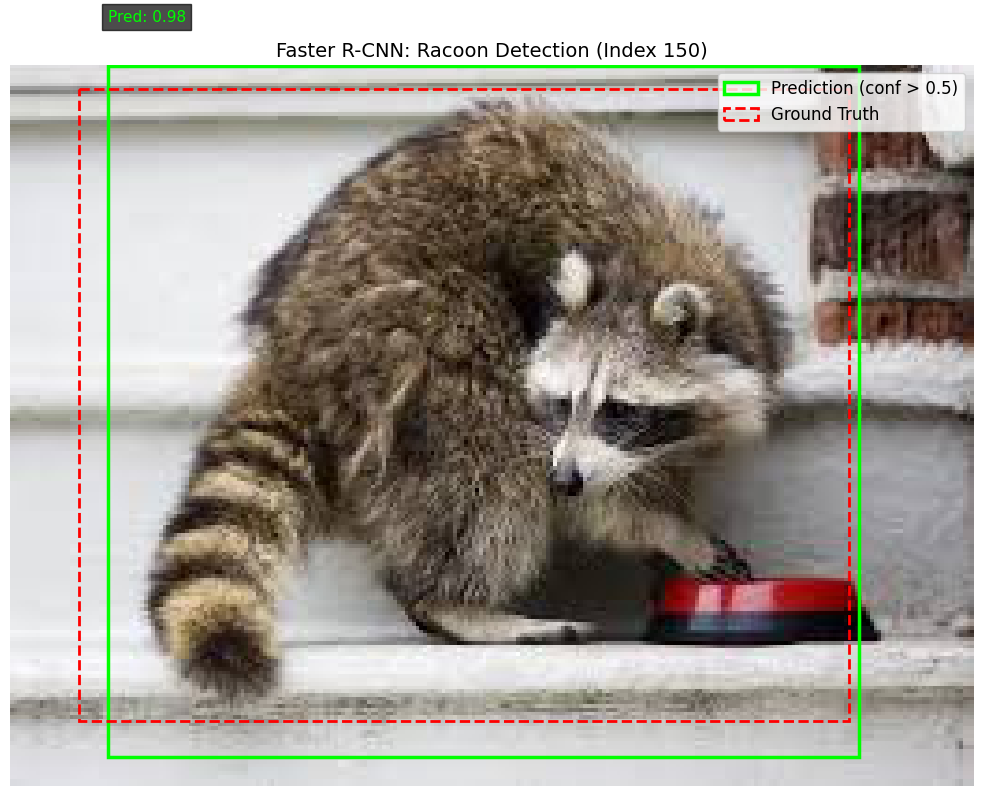

Predictions: 3 boxes
High-conf (>0.5): 1
Ground truth: 1 raccoons


In [20]:
# CELL 7 – FINAL: Safe & Working Inference
model.eval()

# Use a valid index (0 to 159)
test_idx = 150  # or any number < 160
print(f"Testing on image index: {test_idx} (out of {len(full_ds)-1})")

img, gt = full_ds[test_idx]

with torch.no_grad():
    pred = model([img.to(device)])[0]

# Plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(12, 8))
plt.imshow(img.permute(1, 2, 0).cpu().numpy())

# Predictions (Lime)
for box, score in zip(pred['boxes'], pred['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box.cpu().numpy()
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=2.5, edgecolor='lime', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1-12, f'Pred: {score:.2f}', color='lime', fontsize=11,
                 bbox=dict(facecolor='black', alpha=0.7))

# Ground Truth (Red dashed)
for box in gt['boxes']:
    x1, y1, x2, y2 = box.cpu().numpy()
    w, h = x2 - x1, y2 - y1
    rect = patches.Rectangle((x1, y1), w, h,
                             linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
    plt.gca().add_patch(rect)

plt.legend(['Prediction (conf > 0.5)', 'Ground Truth'], loc='upper right', fontsize=12)
plt.title(f"Faster R-CNN: Racoon Detection (Index {test_idx})", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print stats
print(f"Predictions: {len(pred['scores'])} boxes")
print(f"High-conf (>0.5): {(pred['scores'] > 0.5).sum().item()}")
print(f"Ground truth: {len(gt['boxes'])} raccoons")